In [34]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
import random
import shutil
import cv2
import pandas as pd
from PIL import Image
from glob import glob
import numpy as np
from matplotlib import pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score,roc_curve, auc
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG19, MobileNetV3Small, ResNet152
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, concatenate, GlobalAveragePooling2D, Input, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


In [2]:
augmented_dataset_path = 'dullrazor_augmented'


#class_directories = [d for d in os.listdir(augmented_dataset_path) if os.path.isdir(os.path.join(augmented_dataset_path, d))]
class_directories = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#a dictionary to store the class names and their corresponding image counts
class_image_counts = {}

# Count the number of images in each class
for class_name in class_directories:
    class_path = os.path.join(augmented_dataset_path, class_name)
    num_images = len(os.listdir(class_path))
    class_image_counts[class_name] = num_images

# Print the class distribution
print("Class distribution in the augmented dataset:")
print(class_image_counts)


Class distribution in the augmented dataset:
{'akiec': 3151, 'bcc': 2727, 'bkl': 1000, 'df': 1362, 'mel': 1000, 'nv': 1000, 'vasc': 1437}


In [3]:
class_directories

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [4]:
#lists to store image names, paths, and classes
image_names = []
image_paths = []
image_classes = []

# Iterate through each class and collect image information
for class_name in class_directories:
    class_path = os.path.join(augmented_dataset_path, class_name)
    for image_name in os.listdir(class_path):
        if image_name!=".amlignore" and image_name!=".amlignore.amltmp":
            image_names.append(image_name)
            image_paths.append(os.path.join(class_path, image_name))
            image_classes.append(class_name)

#DataFrame from the collected information
data = {
    'Image_Name': image_names,
    'Image_Path': image_paths,
    'Class': image_classes
}

df = pd.DataFrame(data)

#the DataFrame to verify the results
print(df)


                 Image_Name                                      Image_Path  \
0         augmented_0_0.jpg     dullrazor_augmented/akiec/augmented_0_0.jpg   
1         augmented_0_1.jpg     dullrazor_augmented/akiec/augmented_0_1.jpg   
2       augmented_0_100.jpg   dullrazor_augmented/akiec/augmented_0_100.jpg   
3      augmented_0_1004.jpg  dullrazor_augmented/akiec/augmented_0_1004.jpg   
4      augmented_0_1013.jpg  dullrazor_augmented/akiec/augmented_0_1013.jpg   
...                     ...                                             ...   
11670      ISIC_0072937.jpg       dullrazor_augmented/vasc/ISIC_0072937.jpg   
11671      ISIC_0072964.jpg       dullrazor_augmented/vasc/ISIC_0072964.jpg   
11672      ISIC_0073012.jpg       dullrazor_augmented/vasc/ISIC_0073012.jpg   
11673      ISIC_0073031.jpg       dullrazor_augmented/vasc/ISIC_0073031.jpg   
11674      ISIC_0073110.jpg       dullrazor_augmented/vasc/ISIC_0073110.jpg   

       Class  
0      akiec  
1      akiec  
2     

In [5]:
df['image'] = df.Image_Path.map(lambda x: np.asarray(Image.open(x).resize((150, 112))))
df['cell_type_idx'] = pd.Categorical(df.Class).codes

In [6]:
#To save the dataframe to csv
df.to_csv('dataset_metadata.csv', index=False)

In [7]:
# Get a list of unique classes in the DataFrame
unique_classes = df['Class'].unique()

#lists to store train and test samples
train_samples = []
test_samples = []


train_proportion = 0.8

# Iterate through each class and split samples into train and test sets
for class_name in unique_classes:
    # Get the DataFrame subset for the current class
    class_subset = df[df['Class'] == class_name]

    # Split the subset into train and test sets
    train_subset, test_subset = train_test_split(class_subset, train_size=train_proportion, stratify=class_subset['Class'])

    # Append the train and test subsets to the corresponding lists
    train_samples.append(train_subset)
    test_samples.append(test_subset)

# Concatenate the train and test samples for each class back into DataFrames
train_df = pd.concat(train_samples)
test_df = pd.concat(test_samples)

#shuffle the train and test DataFrames
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

# Print the sizes of the train and test sets for each class
print("Training set sizes for each class:")
print(train_df['Class'].value_counts())

print("\nTesting set sizes for each class:")
print(test_df['Class'].value_counts())


Training set sizes for each class:
Class
akiec    2519
bcc      2181
vasc     1149
df       1089
nv        800
bkl       800
mel       800
Name: count, dtype: int64

Testing set sizes for each class:
Class
akiec    630
bcc      546
vasc     288
df       273
nv       200
mel      200
bkl      200
Name: count, dtype: int64


In [8]:
def prepareimages(images):
    # images is a list of images
    images = np.asarray(images).astype(np.float64)
    images = images[:, :, :, ::-1]
    m0 = np.mean(images[:, :, :, 0])
    m1 = np.mean(images[:, :, :, 1])
    m2 = np.mean(images[:, :, :, 2])
    images[:, :, :, 0] -= m0
    images[:, :, :, 1] -= m1
    images[:, :, :, 2] -= m2
    return images

trainimages = prepareimages(list(train_df.image))
testimages = prepareimages(list(test_df.image))

trainlabels = np.asarray(train_df.cell_type_idx)
testlabels = np.asarray(test_df.cell_type_idx)


In [9]:
train_one_hot_labels = to_categorical(trainlabels, num_classes=7)
test_one_hot_labels = to_categorical(testlabels, num_classes=7)

In [10]:
# VGG19
vgg19_base = VGG19(include_top=False, weights='imagenet', input_shape=(112, 150, 3))
vgg19_gap = GlobalAveragePooling2D()(vgg19_base.output)
vgg19_model = Model(inputs=vgg19_base.input, outputs=vgg19_gap)
vgg19_features_train = vgg19_model.predict(trainimages)
vgg19_features_test = vgg19_model.predict(testimages)

# MobileNetV3Small
MobileNetV3Small_base = MobileNetV3Small(include_top=False, weights='imagenet', input_shape=(112, 150, 3))
MobileNetV3Small_gap = GlobalAveragePooling2D()(MobileNetV3Small_base.output)
MobileNetV3Small_model = Model(inputs=MobileNetV3Small_base.input, outputs=MobileNetV3Small_gap)
MobileNetV3Small_features_train = MobileNetV3Small_model.predict(trainimages)
MobileNetV3Small_features_test = MobileNetV3Small_model.predict(testimages)

# ResNet152
resnet152_base = ResNet152(include_top=False, weights='imagenet', input_shape=(112, 150, 3))
resnet152_gap = GlobalAveragePooling2D()(resnet152_base.output)
resnet152_model = Model(inputs=resnet152_base.input, outputs=resnet152_gap)
resnet152_features_train = resnet152_model.predict(trainimages)
resnet152_features_test = resnet152_model.predict(testimages)

2023-08-02 09:57:06.012281: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-02 09:57:10.455627: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1882540800 exceeds 10% of free system memory.
2023-08-02 10:02:29.820137: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1882540800 exceeds 10% of free system memory.
2023-08-02 10:02:54.726880: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1882540800 exceeds 10% of free system memory.


74/74 [==============================] - 54s 722ms/step


In [22]:
# saving the models
vgg19_model.save("vgg19.h5")
MobileNetV3Small_model.save("mobilenetv3small.h5")
resnet152_model.save("resnet152.h5")

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
#normalize the features
F_vgg_normalized = normalize(vgg19_features_train, norm='l2', axis=1)
MobileNetV3Small_normalized = normalize(MobileNetV3Small_features_train, norm='l2', axis=1)
F_resnet_normalized = normalize(resnet152_features_train, norm='l2', axis=1)

In [25]:
# dimensions of each feature vector
dim_vgg = F_vgg_normalized.shape[1]
dim_mobilenet = MobileNetV3Small_normalized.shape[1]
dim_resnet = F_resnet_normalized.shape[1]

# input layers for each feature vector
input_vgg = Input(shape=(dim_vgg,))
input_mobilenet = Input(shape=(dim_mobilenet,))
input_resnet = Input(shape=(dim_resnet,))

# Fully connected layers for each input with Batch Normalization and Dropout
fc_vgg = Dense(256)(input_vgg)
fc_vgg = BatchNormalization()(fc_vgg)
fc_vgg = LeakyReLU()(fc_vgg)
fc_vgg = Dropout(0.3)(fc_vgg)

fc_mobilenet = Dense(256)(input_mobilenet)
fc_mobilenet = BatchNormalization()(fc_mobilenet)
fc_mobilenet = LeakyReLU()(fc_mobilenet)
fc_mobilenet = Dropout(0.3)(fc_mobilenet)

fc_resnet = Dense(256)(input_resnet)
fc_resnet = BatchNormalization()(fc_resnet)
fc_resnet = LeakyReLU()(fc_resnet)
fc_resnet = Dropout(0.3)(fc_resnet)

# Concatenate the output of fully connected layers
merged = concatenate([fc_vgg, fc_mobilenet, fc_resnet])

# Additional fully connected layers for feature fusion with Batch Normalization and Dropout
fusion_fc = Dense(256)(merged)
fusion_fc = BatchNormalization()(fusion_fc)
fusion_fc = LeakyReLU()(fusion_fc)
fusion_fc = Dropout(0.3)(fusion_fc)

fusion_fc = Dense(128)(fusion_fc)
fusion_fc = BatchNormalization()(fusion_fc)
fusion_fc = LeakyReLU()(fusion_fc)
fusion_fc = Dropout(0.3)(fusion_fc)

# Classification layer
output_layer = Dense(7, activation='softmax')(fusion_fc)

# Create the fusion model
fusion_model = Model(inputs=[input_vgg, input_mobilenet, input_resnet], outputs=output_layer)

# Compile the model with a reduced learning rate
optimizer = Adam(learning_rate=0.0001)
fusion_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [26]:
'''
# dimensions of each feature vector
dim_vgg = F_vgg_normalized.shape[1]
dim_mobilenet = MobileNetV3Small_normalized.shape[1]
dim_resnet = F_resnet_normalized.shape[1]

# input layers for each feature vector
input_vgg = Input(shape=(dim_vgg,))
input_mobilenet = Input(shape=(dim_mobilenet,))
input_resnet = Input(shape=(dim_resnet,))

# Fully connected layers for each input
fc_vgg = Dense(256, activation='relu')(input_vgg)
fc_mobilenet = Dense(256, activation='relu')(input_mobilenet)
fc_resnet = Dense(256, activation='relu')(input_resnet)

# Concatenate the output of fully connected layers
merged = concatenate([fc_vgg, fc_mobilenet, fc_resnet])

# Additional fully connected layers for feature fusion
fusion_fc = Dense(256, activation='relu')(merged)
fusion_fc = Dense(128, activation='relu')(fusion_fc)

# Classification layer
output_layer = Dense(7, activation='softmax')(fusion_fc)

# Create the fusion model
fusion_model = Model(inputs=[input_vgg, input_mobilenet, input_resnet], outputs=output_layer)

# Compile the model
fusion_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])'''


"\n# dimensions of each feature vector\ndim_vgg = F_vgg_normalized.shape[1]\ndim_mobilenet = MobileNetV3Small_normalized.shape[1]\ndim_resnet = F_resnet_normalized.shape[1]\n\n# input layers for each feature vector\ninput_vgg = Input(shape=(dim_vgg,))\ninput_mobilenet = Input(shape=(dim_mobilenet,))\ninput_resnet = Input(shape=(dim_resnet,))\n\n# Fully connected layers for each input\nfc_vgg = Dense(256, activation='relu')(input_vgg)\nfc_mobilenet = Dense(256, activation='relu')(input_mobilenet)\nfc_resnet = Dense(256, activation='relu')(input_resnet)\n\n# Concatenate the output of fully connected layers\nmerged = concatenate([fc_vgg, fc_mobilenet, fc_resnet])\n\n# Additional fully connected layers for feature fusion\nfusion_fc = Dense(256, activation='relu')(merged)\nfusion_fc = Dense(128, activation='relu')(fusion_fc)\n\n# Classification layer\noutput_layer = Dense(7, activation='softmax')(fusion_fc)\n\n# Create the fusion model\nfusion_model = Model(inputs=[input_vgg, input_mobilene

In [27]:
history1 = fusion_model.fit(
    [F_vgg_normalized, MobileNetV3Small_normalized, F_resnet_normalized],
    train_one_hot_labels,
    batch_size=64,
    epochs=70,
    shuffle=True,
    validation_split=0.2
)

Epoch 1/70
117/117 [==============================] - 3s 10ms/step - loss: 1.4997 - accuracy: 0.4510 - val_loss: 1.7781 - val_accuracy: 0.4347
Epoch 2/70
117/117 [==============================] - 1s 8ms/step - loss: 1.0695 - accuracy: 0.6149 - val_loss: 1.5565 - val_accuracy: 0.5980
Epoch 3/70
117/117 [==============================] - 1s 8ms/step - loss: 0.9297 - accuracy: 0.6633 - val_loss: 1.2544 - val_accuracy: 0.6884
Epoch 4/70
117/117 [==============================] - 1s 8ms/step - loss: 0.8264 - accuracy: 0.6950 - val_loss: 0.9576 - val_accuracy: 0.7297
Epoch 5/70
117/117 [==============================] - 1s 8ms/step - loss: 0.7587 - accuracy: 0.7216 - val_loss: 0.7485 - val_accuracy: 0.7543
Epoch 6/70
117/117 [==============================] - 1s 7ms/step - loss: 0.7144 - accuracy: 0.7

In [28]:
# Saving the classification model
fusion_model.save("prediction_model.h5")

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
#normalization for test features
F_vgg_normalized_test = normalize(vgg19_features_test, norm='l2', axis=1)
MobileNetV3Small_normalized_test = normalize(MobileNetV3Small_features_test, norm='l2', axis=1)
F_resnet_normalized_test = normalize(resnet152_features_test, norm='l2', axis=1)


In [30]:
# Accuracy
test_loss, test_accuracy = fusion_model.evaluate([F_vgg_normalized_test,MobileNetV3Small_normalized_test,F_resnet_normalized_test], test_one_hot_labels)
print("Test Accuracy:", test_accuracy)

# F1 Score
test_predictions = fusion_model.predict([F_vgg_normalized_test,MobileNetV3Small_normalized_test,F_resnet_normalized_test])
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_one_hot_labels, axis=1)
f1 = f1_score(test_true_classes, test_predictions_classes, average='weighted')
print("F1 Score:", f1)

# AUC-ROC Score
roc_auc = roc_auc_score(test_one_hot_labels, test_predictions, multi_class='ovr', average='weighted')
print("AUC-ROC Score:", roc_auc)

74/74 [==============================] - 0s 2ms/step - loss: 0.6176 - accuracy: 0.8297
Test Accuracy: 0.8296961784362793
74/74 [==============================] - 0s 2ms/step
F1 Score: 0.8300111644601622
AUC-ROC Score: 0.9769104850800208


In [31]:
report = classification_report(test_true_classes, test_predictions_classes)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       630
           1       0.86      0.83      0.84       546
           2       0.67      0.61      0.64       200
           3       0.92      0.88      0.90       273
           4       0.61      0.67      0.63       200
           5       0.75      0.77      0.76       200
           6       0.96      0.94      0.95       288

    accuracy                           0.83      2337
   macro avg       0.80      0.80      0.80      2337
weighted avg       0.83      0.83      0.83      2337



In [32]:
image=cv2.imread('dullrazor_augmented/akiec/augmented_0_0.jpg',cv2.IMREAD_COLOR)
#Image cropping
img=image
grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
kernel = cv2.getStructuringElement(1,(9,9))
blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
#ret=np.array(ret)
mask = mask.astype(np.uint8)
dst = cv2.inpaint(img,mask,6,cv2.INPAINT_TELEA)

In [33]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Load and preprocess the single image
image_path = 'dullrazor_augmented/akiec/augmented_0_0.jpg'
img = load_img(image_path, target_size=(112, 150))
print(img)

img_array = img_to_array(img)
print(img_array.dtype)
img_array = np.expand_dims(img_array, axis=0)
images = img_array[:, :, :, ::-1]
m0 = np.mean(images[:, :, :, 0])
m1 = np.mean(images[:, :, :, 1])
m2 = np.mean(images[:, :, :, 2])
images[:, :, :, 0] -= m0
images[:, :, :, 1] -= m1
images[:, :, :, 2] -= m2
print(img_array.shape)

# Extract features using the pre-trained models
vgg19_features = vgg19_model.predict(images)
MobileNetV3Small_features = MobileNetV3Small_model.predict(images)
resnet_features = resnet152_model.predict(images)

F_vgg_normalized = normalize(vgg19_features, norm='l2', axis=1)
MobileNetV3Small_normalized = normalize(MobileNetV3Small_features, norm='l2', axis=1)
F_resnet_normalized = normalize(resnet_features, norm='l2', axis=1)

# Make prediction on the single image
prediction = fusion_model.predict([F_vgg_normalized,MobileNetV3Small_normalized,F_resnet_normalized])
predicted_class = np.argmax(prediction)

#class labels
class_labels = ['akiec','bcc','bkl','df','mel','nv','vasc']

# Print the predicted class
print("Predicted class:", class_labels[predicted_class])


<PIL.Image.Image image mode=RGB size=150x112 at 0x7EFD2F6CE860>
float32
(1, 112, 150, 3)
1/1 [==============================] - 0s 18ms/step
Predicted class: akiec


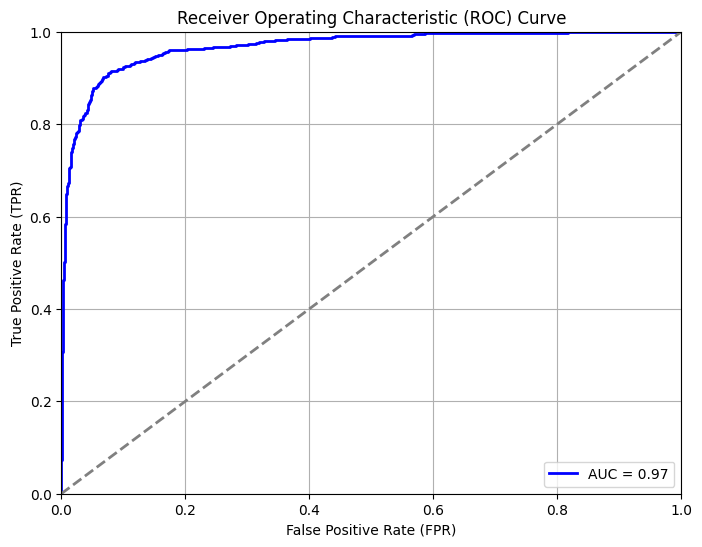

In [35]:
# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(test_one_hot_labels[:, 1], test_predictions[:, 1])

# Compute the AUC (Area Under the Curve) score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()